In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/code/phasor_julia`


In [2]:
include("src/spiking.jl")
include("src/vsa.jl")

similarity_outer (generic function with 1 method)

In [3]:
using Plots

In [4]:
repeats = 6

6

In [34]:
tspan = (0.0, 1.0 * repeats)

(0.0, 6.0)

In [5]:
n_angles = 101

101

In [17]:
phase_0 = reshape([0.0], (1,1))

1×1 Matrix{Float64}:
 0.0

In [19]:
phases = reshape(range(start = -1.0, stop = 1.0, length = n_angles) |> collect, (1, n_angles))

1×101 Matrix{Float64}:
 -1.0  -0.98  -0.96  -0.94  -0.92  -0.9  …  0.9  0.92  0.94  0.96  0.98  1.0

In [20]:
s = similarity(phase_0, phases)

1×101 Matrix{Float64}:
 -1.0  -0.998027  -0.992115  -0.982287  …  -0.992115  -0.998027  -1.0

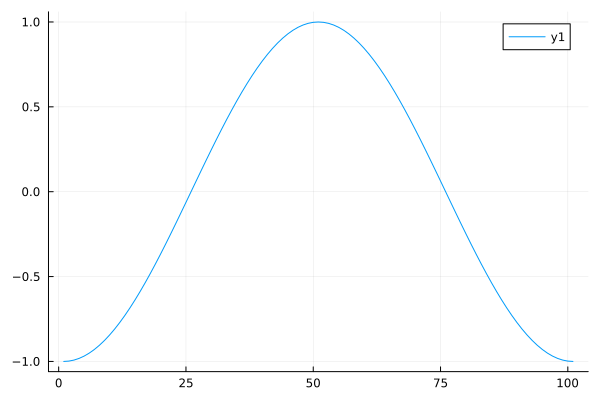

In [22]:
plot(s |> vec)

In [23]:
cmpx(x) = exp.(0.0 + 1.0im * pi * x)

cmpx (generic function with 1 method)

In [24]:
c_phase0 = cmpx.(phase_0)
c_phase = cmpx.(phases);

In [25]:
cmpx_interference = c_phase0 .+ c_phase;

In [26]:
absvals = abs.(cmpx_interference)

1×101 Matrix{Float64}:
 1.22465e-16  0.0628215  0.125581  …  0.125581  0.0628215  1.22465e-16

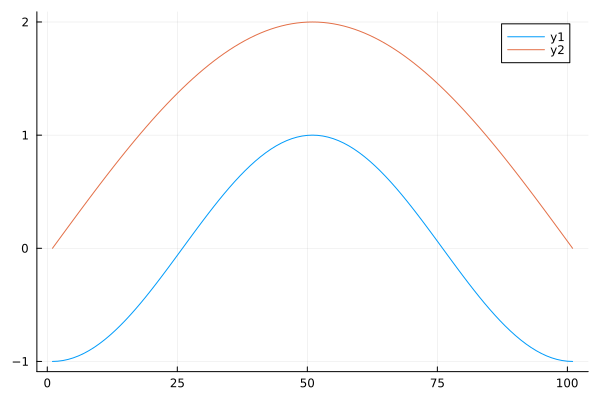

In [27]:
plot(s |> vec)
plot!(absvals |> vec)

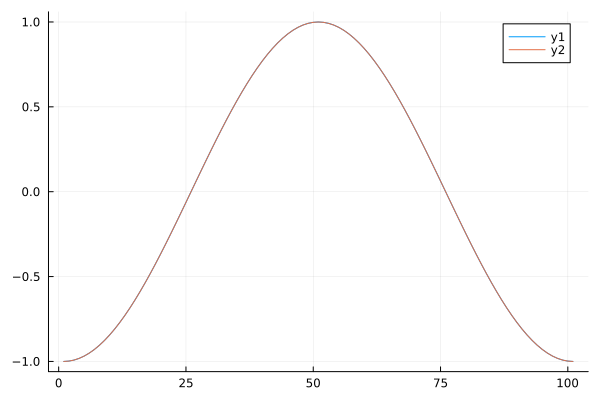

In [29]:
plot(s |> vec)
plot!(cos.(2 .* acos.((absvals |> vec) ./ 2)))

In [30]:
spk_args = SpikingArgs()

Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.02 (V)


In [31]:
st_0 = phase_to_train(phase_0, spk_args, repeats = repeats)
st_p = phase_to_train(phases, spk_args, repeats = repeats)

Spike Train: (1, 101) with 606 spikes.

In [32]:
using OrdinaryDiffEq

In [33]:
function phase_memory(x::SpikeTrain; tspan::Tuple{<:Real, <:Real} = (0.0, 10.0), spk_args::SpikingArgs = default_spk_args())
    #set up functions to define the neuron's differential equations
    k = neuron_constant(spk_args)

    #set up compartments for each sample
    u0 = zeros(ComplexF32, x.shape)
    #resonate in time with the input spikes
    dzdt(u, p, t) = k .* u .+ spike_current(x, t, spk_args)
    #solve the memory compartment
    prob = ODEProblem(dzdt, u0, tspan)
    sol = solve(prob, Heun(), adaptive=false, dt=spk_args.dt)

    return sol
end

phase_memory (generic function with 1 method)

In [36]:
sol_0 = phase_memory(st_0, tspan=tspan, spk_args=spk_args);

In [38]:
sol_phase = phase_memory(st_p, tspan=tspan, spk_args=spk_args);

In [39]:
u_0 = Array(sol_0)
u_phase = Array(sol_phase);

In [47]:
interference = scale_potential.(u_0) .+ scale_potential.(u_phase);

In [48]:
interference |> size

(1, 101, 601)

In [49]:
mag = abs.(interference);

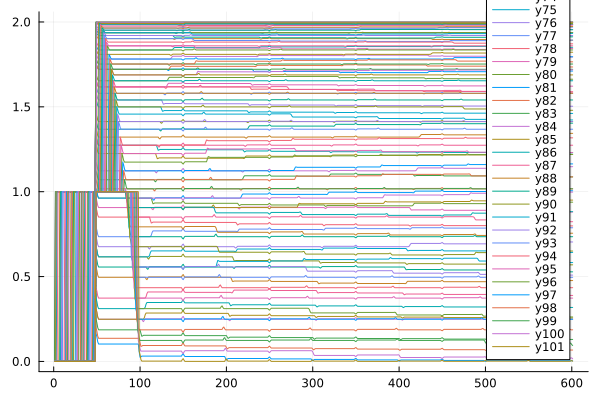

In [51]:
plot(mag[1,:,:]')

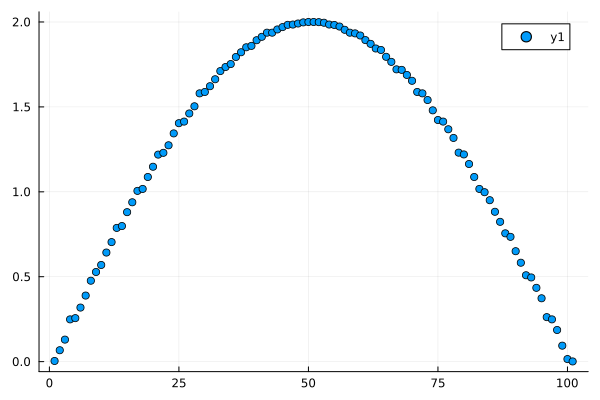

In [53]:
scatter(mag[1,:,end])

In [58]:
sim_spiking = cos.( 2.0 .* acos.(0.5 .* mag[1,:,end]))

101-element Vector{Float64}:
 -0.9999926903851111
 -0.9977490227385547
 -0.9916035030659155
 -0.9690551721388303
 -0.9672187890739945
 -0.949351886079512
 -0.9243525306436009
 -0.8865022300815308
 -0.8607052307193044
 -0.8380349355012678
  ⋮
 -0.8771432507752935
 -0.9055837758894949
 -0.9304457058698749
 -0.9656893692465575
 -0.9690551387753173
 -0.9826501033784253
 -0.9955881794697188
 -0.9998869852716644
 -0.9999993495713748

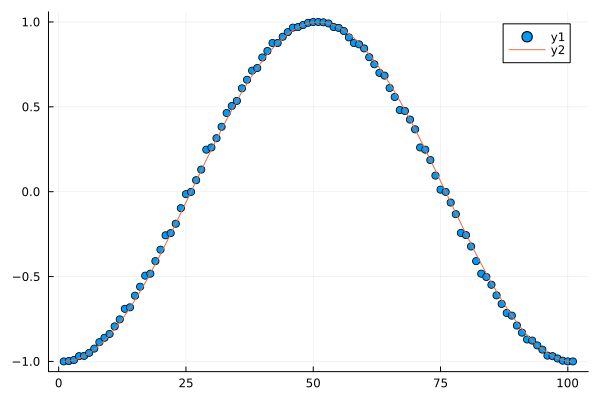

In [59]:
scatter(sim_spiking)
plot!(s |> vec)

In [64]:
err = vec(sim_spiking) .- vec(s);

In [65]:
err |> size

(101,)

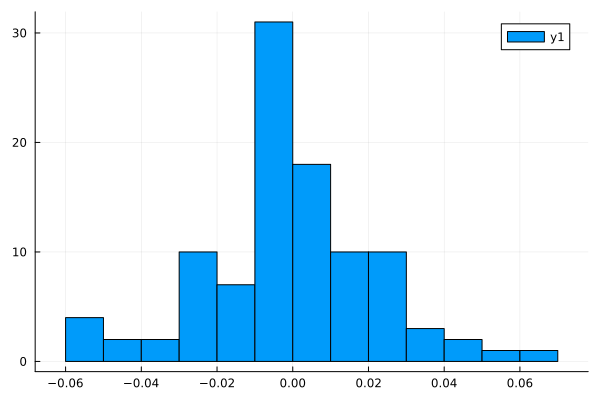

In [66]:
histogram(err |> vec)